In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("time_series_data.csv")
df_train = df[df["Year"] <= 2023]
df_test = df[df["Year"] > 2023]

categorical_cols = ["location_name"]
numerical_cols = ["sin_month", "cos_month", "Year", "Month", "num_days", "holiday_num"]
numerical_features = [
    "crime_count",
    "crime_pct_change",
    "morning",
    "afternoon",
    "evening",
    "night",
    "domestic",
    "arrest",
]
for i in [1, 2, 3, 6, 12]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_lag{i}")
for i in [3, 6]:
    for j in numerical_features:
        numerical_cols.append(f"{j}_ma{i}")

X_train = df_train[categorical_cols + numerical_cols]
y_train = df_train["crime_count"]
X_test = df_test[categorical_cols + numerical_cols]
y_test = df_test["crime_count"]

cat_pipe = Pipeline(
    [
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat_pipe", cat_pipe, categorical_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())],
)

model.fit(X_train, y_train)

lr_train_pred = model.predict(X_train)
lr_pred = model.predict(X_test)
lr_train_pred = np.round(lr_train_pred)
lr_pred = np.round(lr_pred)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)

rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_pred = rf_model.predict(X_test)
rf_train_pred = np.round(rf_train_pred)
rf_pred = np.round(rf_pred)

rf_rmse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae_percentage = (rf_mae / y_test.mean()) * 100

print(f"Random Forest Results:")
print(f"Mean Squared Error: {rf_rmse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {rf_mae_percentage:.2f}%")



Random Forest Results:
Mean Squared Error: 24652.88
Mean Absolute Error: 53.29
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 7.16%


In [3]:
xg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree),
        (
            "regressor",
            XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=7,
                gamma=0.1,
                random_state=42,
            ),
        ),
    ]
)
xg_model.fit(X_train, y_train)
xg_train_pred = xg_model.predict(X_train)
xg_pred = xg_model.predict(X_test)
xg_train_pred = np.round(xg_train_pred)
xg_pred = np.round(xg_pred)

xg_rmse = mean_squared_error(y_test, xg_pred)
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_r2 = r2_score(y_test, xg_pred)
xg_mae_percentage = (xg_mae / y_test.mean()) * 100
print(f"XGBoost Results:")
print(f"Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Error: {xg_mae:.2f}")
print(f"R² Score: {xg_r2:.2f}")
print(f"Normalized Mean Absolute Error Percentage: {xg_mae_percentage:.2f}%")

param_grid = {
    "regressor__n_estimators": [200],
    "regressor__learning_rate": [0.1],
    "regressor__max_depth": [5],
    "regressor__min_child_weight": [5],
    "regressor__gamma": [0.1],
}

xg_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor(random_state=42))]
)

grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=5,  
    scoring="neg_mean_squared_error",
    n_jobs=-1,  
    verbose=1,  
)

print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

xg_res = y_test - y_test_pred

df_train_result = df_train.copy()
df_test_result = df_test.copy()
df_lstm = pd.read_csv("lstm_predictions.csv")
df_cnn = pd.read_csv("cnn_predictions.csv")
df_lstm[["location_id", "crime_count", "lstm_pred", "time_id"]]
df_cnn = df_cnn[["location_id", "time_id", "cnn_pred", "Year"]]

df_train_lstm = df_lstm[df_lstm["Year"] <= 2023]
df_test_lstm = df_lstm[df_lstm["Year"] > 2023]
df_train_result = df_train_result.merge(
    df_train_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_test_result = df_test_result.merge(
    df_test_lstm[["location_id", "time_id", "lstm_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_train_cnn = df_cnn[df_cnn["Year"] <= 2023]
df_test_cnn = df_cnn[df_cnn["Year"] > 2023]

df_train_result = df_train_result.merge(
    df_train_cnn[["location_id", "time_id", "cnn_pred"]],
    on=["location_id", "time_id"],
    how="left",
)
df_test_result = df_test_result.merge(
    df_test_cnn[["location_id", "time_id", "cnn_pred"]],
    on=["location_id", "time_id"],
    how="left",
)

df_train_result["lr_pred"] = lr_train_pred
df_train_result["rf_pred"] = rf_train_pred
df_train_result["xg_pred"] = xg_train_pred
df_test_result["lr_pred"] = lr_pred
df_test_result["rf_pred"] = rf_pred
df_test_result["xg_pred"] = xg_pred
df_train_result["lstm_pred"] = df_train_result["lstm_pred"]
df_test_result["lstm_pred"] = df_test_result["lstm_pred"]

df_train_result["lr_res"] = df_train_result["crime_count"] - df_train_result["lr_pred"]
df_train_result["rf_res"] = df_train_result["crime_count"] - df_train_result["rf_pred"]
df_train_result["xg_res"] = df_train_result["crime_count"] - df_train_result["xg_pred"]
df_train_result["lstm_res"] = (
    df_train_result["crime_count"] - df_train_result["lstm_pred"]
)
df_test_result["lr_res"] = df_test_result["crime_count"] - df_test_result["lr_pred"]
df_test_result["rf_res"] = df_test_result["crime_count"] - df_test_result["rf_pred"]
df_test_result["xg_res"] = df_test_result["crime_count"] - df_test_result["xg_pred"]
df_test_result["lstm_res"] = df_test_result["crime_count"] - df_test_result["lstm_pred"]
df_test_result[
    ["time_id", "location_id", "crime_count", "xg_pred", "lr_pred", "rf_pred"]
]
df_train_result["cnn_res"] = df_train_result["crime_count"] - df_train_result["cnn_pred"]
df_test_result["cnn_res"] = df_test_result["crime_count"] - df_test_result["cnn_pred"]

# summarize the results (metrics)
def summarize_results(df, model):
    rmse = mean_squared_error(df["crime_count"], df[model])
    mae = mean_absolute_error(df["crime_count"], df[model])
    r2 = r2_score(df["crime_count"], df[model])
    mean_value = df["crime_count"].mean()
    mae_percentage = (mae / mean_value) * 100
    return rmse, mae, r2, mae_percentage

for m in ["lr", "rf", "xg", "lstm", "cnn"]:
    rmse, mae, r2, mae_percentage = summarize_results(df_test_result, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

# 1. MONTHLY AGGREGATION PLOTS
# ============================

# Aggregate by month

monthly_train = (
    df_train_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
            "cnn_pred": "sum",  # Added CNN predictions
        }
    )
    .reset_index()
)

# Aggregate by month for test data, including CNN predictions
monthly_test = (
    df_test_result.groupby(["Year", "Month"])
    .agg(
        {
            "crime_count": "sum",
            "lr_pred": "sum",
            "rf_pred": "sum",
            "xg_pred": "sum",
            "lstm_pred": "sum",
            "cnn_pred": "sum",  # Added CNN predictions
        }
    )
    .reset_index()
)


XGBoost Results:
Mean Squared Error: 19519.46
Mean Absolute Error: 50.88
R² Score: 0.99
Normalized Mean Absolute Error Percentage: 6.84%
Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Grid search completed!
Best parameters: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200}

Model Performance:
Training RMSE: 162.4563
Training R²: 1.0000
Testing RMSE: 16174.0234
Testing R²: 0.9954
Model: lr
RMSE	R²	MAE	MAE Percentage
17687.27	0.99	56.13	7.55%


Model: rf
RMSE	R²	MAE	MAE Percentage
24652.88	0.99	53.29	7.16%


Model: xg
RMSE	R²	MAE	MAE Percentage
19519.46	0.99	50.88	6.84%


Model: lstm
RMSE	R²	MAE	MAE Percentage
18896.09	0.99	47.69	6.41%


Model: cnn
RMSE	R²	MAE	MAE Percentage
17872.03	0.99	50.83	6.83%




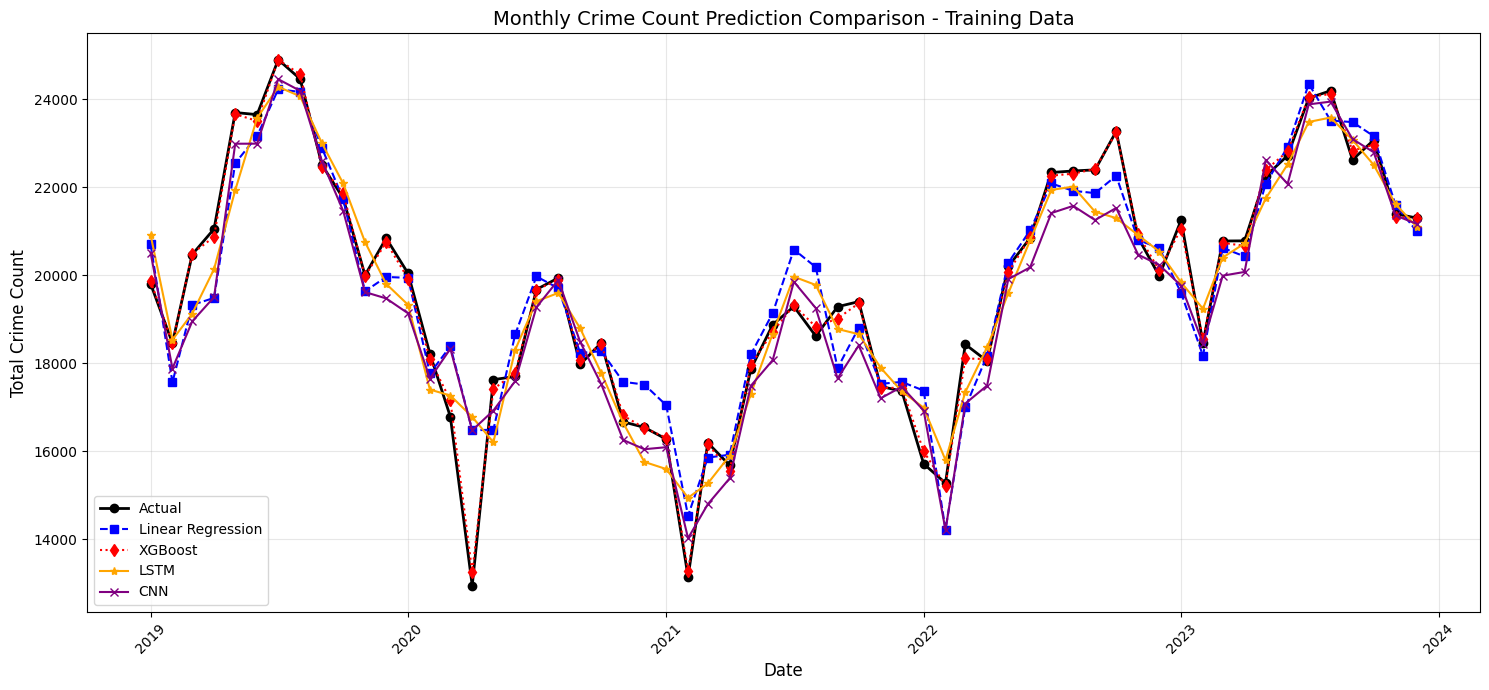

In [4]:
# Create date columns
monthly_train["date"] = pd.to_datetime(
    monthly_train["Year"].astype(str) + "-" + monthly_train["Month"].astype(str) + "-01"
)
monthly_test["date"] = pd.to_datetime(
    monthly_test["Year"].astype(str) + "-" + monthly_test["Month"].astype(str) + "-01"
)

# Sort by date
monthly_train = monthly_train.sort_values("date")
monthly_test = monthly_test.sort_values("date")

y_test_monthly = monthly_test["crime_count"]

# Plot monthly comparison - Training data
plt.figure(figsize=(15, 7))
plt.plot(
    monthly_train["date"],
    monthly_train["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
# plt.plot(
#     monthly_train["date"],
#     monthly_train["rf_pred"],
#     marker="^",
#     linestyle="-.",
#     label="Random Forest",
#     color="green",
# )
plt.plot(
    monthly_train["date"],
    monthly_train["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_train["date"],
    monthly_train["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.plot(
    monthly_train["date"],
    monthly_train["cnn_pred"],
    marker="x",  
    linestyle="-",
    label="CNN",
    color="purple",  
)
plt.title("Monthly Crime Count Prediction Comparison - Training Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_comparison_train_data_with_cnn.pdf", format="pdf")
plt.show()



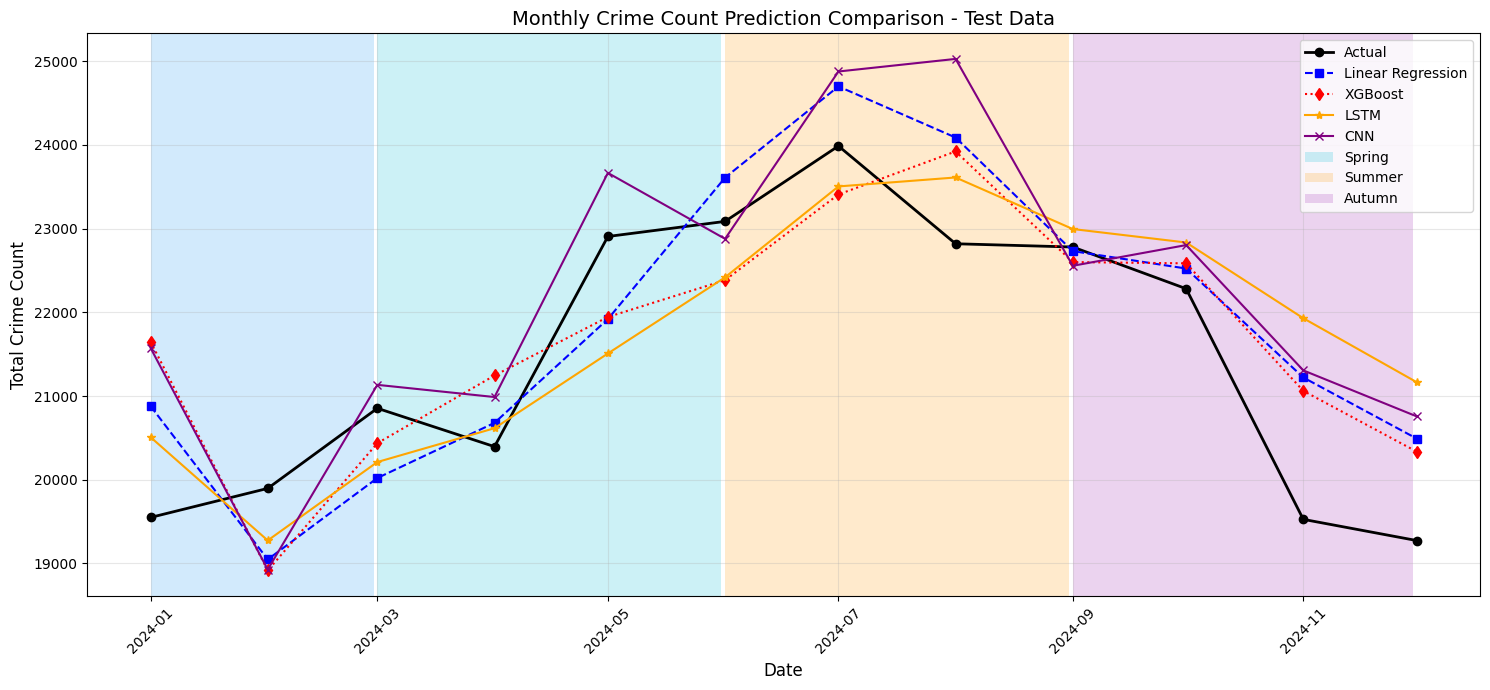

Model: lr
RMSE	R²	MAE	MAE Percentage
920523.33	0.65	832.50	3.88%


Model: rf
RMSE	R²	MAE	MAE Percentage
1315476.42	0.50	922.92	4.30%


Model: xg
RMSE	R²	MAE	MAE Percentage
1070243.88	0.59	897.75	4.19%


Model: lstm
RMSE	R²	MAE	MAE Percentage
1227776.00	0.53	903.83	4.21%


Model: cnn
RMSE	R²	MAE	MAE Percentage
1454129.77	0.45	995.16	4.64%


   season  lr_mae  xg_mae  lstm_mae  cnn_mae
0  Autumn  834.67  794.67    647.67  1102.33
1  Spring 1132.33 1380.67   1157.67  1492.48
2  Summer  701.33  743.00    753.33   544.10
3  Winter  661.67  672.67   1056.67   841.72


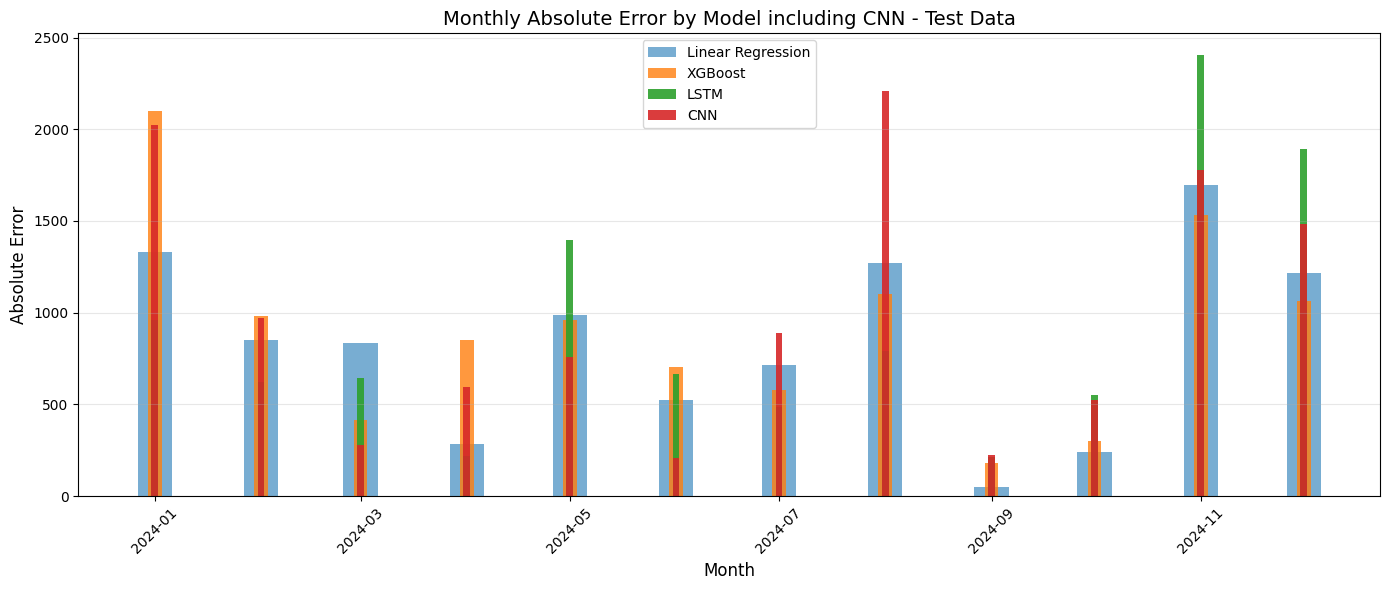

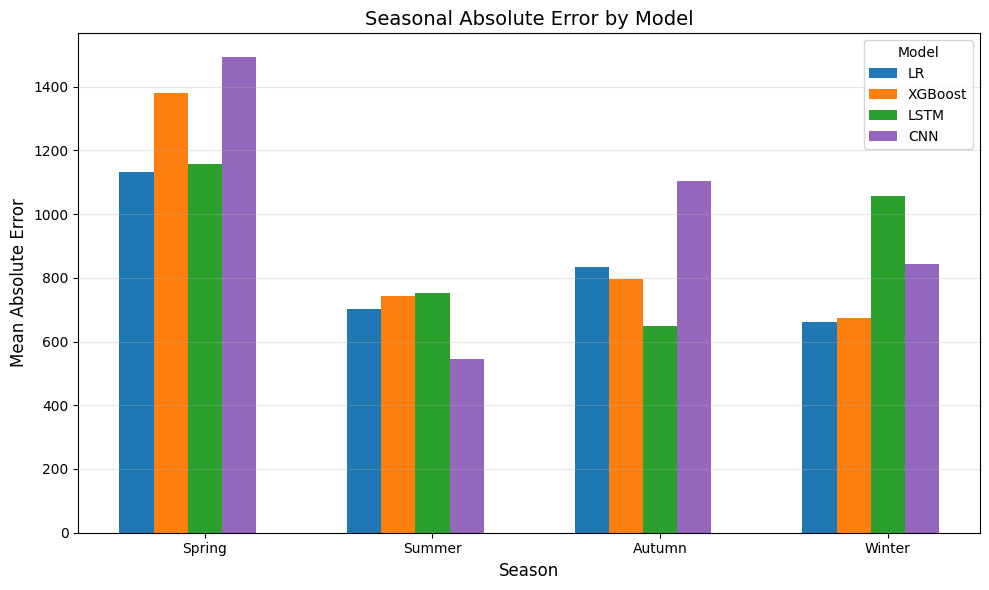

In [22]:
# Plot monthly comparison - Test data
import matplotlib.dates as mdates

# Define season ranges: (start, end, color, label)
season_shades = [
    ("03", "05", "#00bcd4", "Spring"),   # 更鲜明的青蓝色
    ("06", "08", "#ff9800", "Summer"),   # 鲜亮橙色
    ("09", "11", "#9c27b0", "Autumn"),   # 饱和紫色
    ("12", "02", "#2196f3", "Winter"),   # 深蓝色
]


# Shade seasons

plt.figure(figsize=(15, 7))
plt.plot(
    monthly_test["date"],
    monthly_test["crime_count"],
    marker="o",
    linewidth=2,
    label="Actual",
    color="black",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lr_pred"],
    marker="s",
    linestyle="--",
    label="Linear Regression",
    color="blue",
)
# plt.plot(
#     monthly_test["date"],
#     monthly_test["rf_pred"],
#     marker="^",
#     linestyle="-.",
#     label="Random Forest",
#     color="green",
# )
plt.plot(
    monthly_test["date"],
    monthly_test["xg_pred"],
    marker="d",
    linestyle=":",
    label="XGBoost",
    color="red",
)
plt.plot(
    monthly_test["date"],
    monthly_test["lstm_pred"],
    marker="*",
    linestyle="-",
    label="LSTM",
    color="orange",
)
plt.plot(
    monthly_test["date"],
    monthly_test["cnn_pred"],
    marker="x", 
    linestyle="-",
    label="CNN",
    color="purple",  
)
target_year = 2024
for start_month, end_month, color, label in season_shades:
    try:
        if start_month != "12":  
            start_date = pd.to_datetime(f"{target_year}-{start_month}-01")
            end_date = pd.to_datetime(f"{target_year}-{end_month}-01") + pd.offsets.MonthEnd(0)
            plt.axvspan(start_date, end_date, facecolor=color, alpha=0.2, label=label)
        else:  
#             # first half of winter（12月）
#             start_date = pd.to_datetime(f"{target_year}-{start_month}-01")
#             end_date = pd.to_datetime(f"{target_year}-12-31")
#             plt.axvspan(start_date, end_date, facecolor=color, alpha=0.2, label=label)
            
            # second half of winter（1-2月）
            start_date = pd.to_datetime(f"{target_year}-01-01")
            end_date = pd.to_datetime(f"{target_year}-{end_month}-01") + pd.offsets.MonthEnd(0)
            plt.axvspan(start_date, end_date, facecolor=color, alpha=0.2)
    except Exception as e:
        print(f"Error adding season shade: {e}")
        continue


plt.title("Monthly Crime Count Prediction Comparison - Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Crime Count", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("monthly_comparison_test_data_in_seasons.pdf", format="pdf")
plt.show()

for m in ["lr", "rf", "xg", "lstm", "cnn"]:
    rmse, mae, r2, mae_percentage = summarize_results(monthly_test, f"{m}_pred")
    print(f"Model: {m}")
    print(f"RMSE\tR²\tMAE\tMAE Percentage")
    print(f"{rmse:.2f}\t{r2:.2f}\t{mae:.2f}\t{mae_percentage:.2f}%")
    print("\n")

# 2. MODEL PERFORMANCE BY MONTH
# ============================
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Spring'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6,7, 8]:
        return 'Autumn'
    else:  # 10, 11
        return 'Winter'



monthly_test["season"] = monthly_test["Month"].apply(month_to_season)
# Calculate monthly MAE for each model (test data)
monthly_test["lr_mae"] = abs(monthly_test["crime_count"] - monthly_test["lr_pred"])
# monthly_test["rf_mae"] = abs(monthly_test["crime_count"] - monthly_test["rf_pred"])
monthly_test["xg_mae"] = abs(monthly_test["crime_count"] - monthly_test["xg_pred"])
monthly_test["lstm_mae"] = abs(monthly_test["crime_count"] - monthly_test["lstm_pred"])
monthly_test["cnn_mae"] = abs(monthly_test["crime_count"] - monthly_test["cnn_pred"])  # Add CNN MAE



# 按季节计算平均 MAE
seasonal_mae = monthly_test.groupby("season")[["lr_mae", "xg_mae", "lstm_mae", "cnn_mae"]].mean().reset_index()
print(seasonal_mae)
# Plot MAE by month
plt.figure(figsize=(14, 6))
plt.bar(
    monthly_test["date"],
    monthly_test["lr_mae"],
    width=10,
    alpha=0.6,
    label="Linear Regression",
)
# plt.bar(
#     monthly_test["date"],
#     monthly_test["rf_mae"],
#     width=7,
#     alpha=0.7,
#     label="Random Forest",
# )
plt.bar(
    monthly_test["date"],
    monthly_test["xg_mae"],
    width=4,
    alpha=0.8,
    label="XGBoost",
)
plt.bar(
    monthly_test["date"],
    monthly_test["lstm_mae"],
    width=2,
    alpha=0.9,
    label="LSTM",
)
plt.bar(
    monthly_test["date"],
    monthly_test["cnn_mae"],
    width=2,
    alpha=0.9,
    label="CNN",  
)
plt.title("Monthly Absolute Error by Model including CNN - Test Data", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Absolute Error", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3, axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("monthly_absolute_error_by_model_with_cnn_test_data.pdf", format="pdf")
plt.show()

season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_mae = seasonal_mae.set_index('season').loc[season_order].reset_index()

# 模型列表
models = ['lr_mae',  'xg_mae', 'lstm_mae', 'cnn_mae']
model_labels = ['LR', 'XGBoost', 'LSTM', 'CNN']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']

# 设置柱状图参数
bar_width = 0.15
x = np.arange(len(season_order))  # 季节位置

# 开始绘图
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    plt.bar(x + i * bar_width, seasonal_mae[model], width=bar_width, label=model_labels[i], color=colors[i])

# 坐标轴 & 标题
plt.title("Seasonal Absolute Error by Model", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.xticks(x + bar_width * 2, season_order)  # 中心对齐标签
plt.grid(True, alpha=0.3, axis="y")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("seasonal_absolute_error_by_model.pdf", format="pdf")
plt.show()


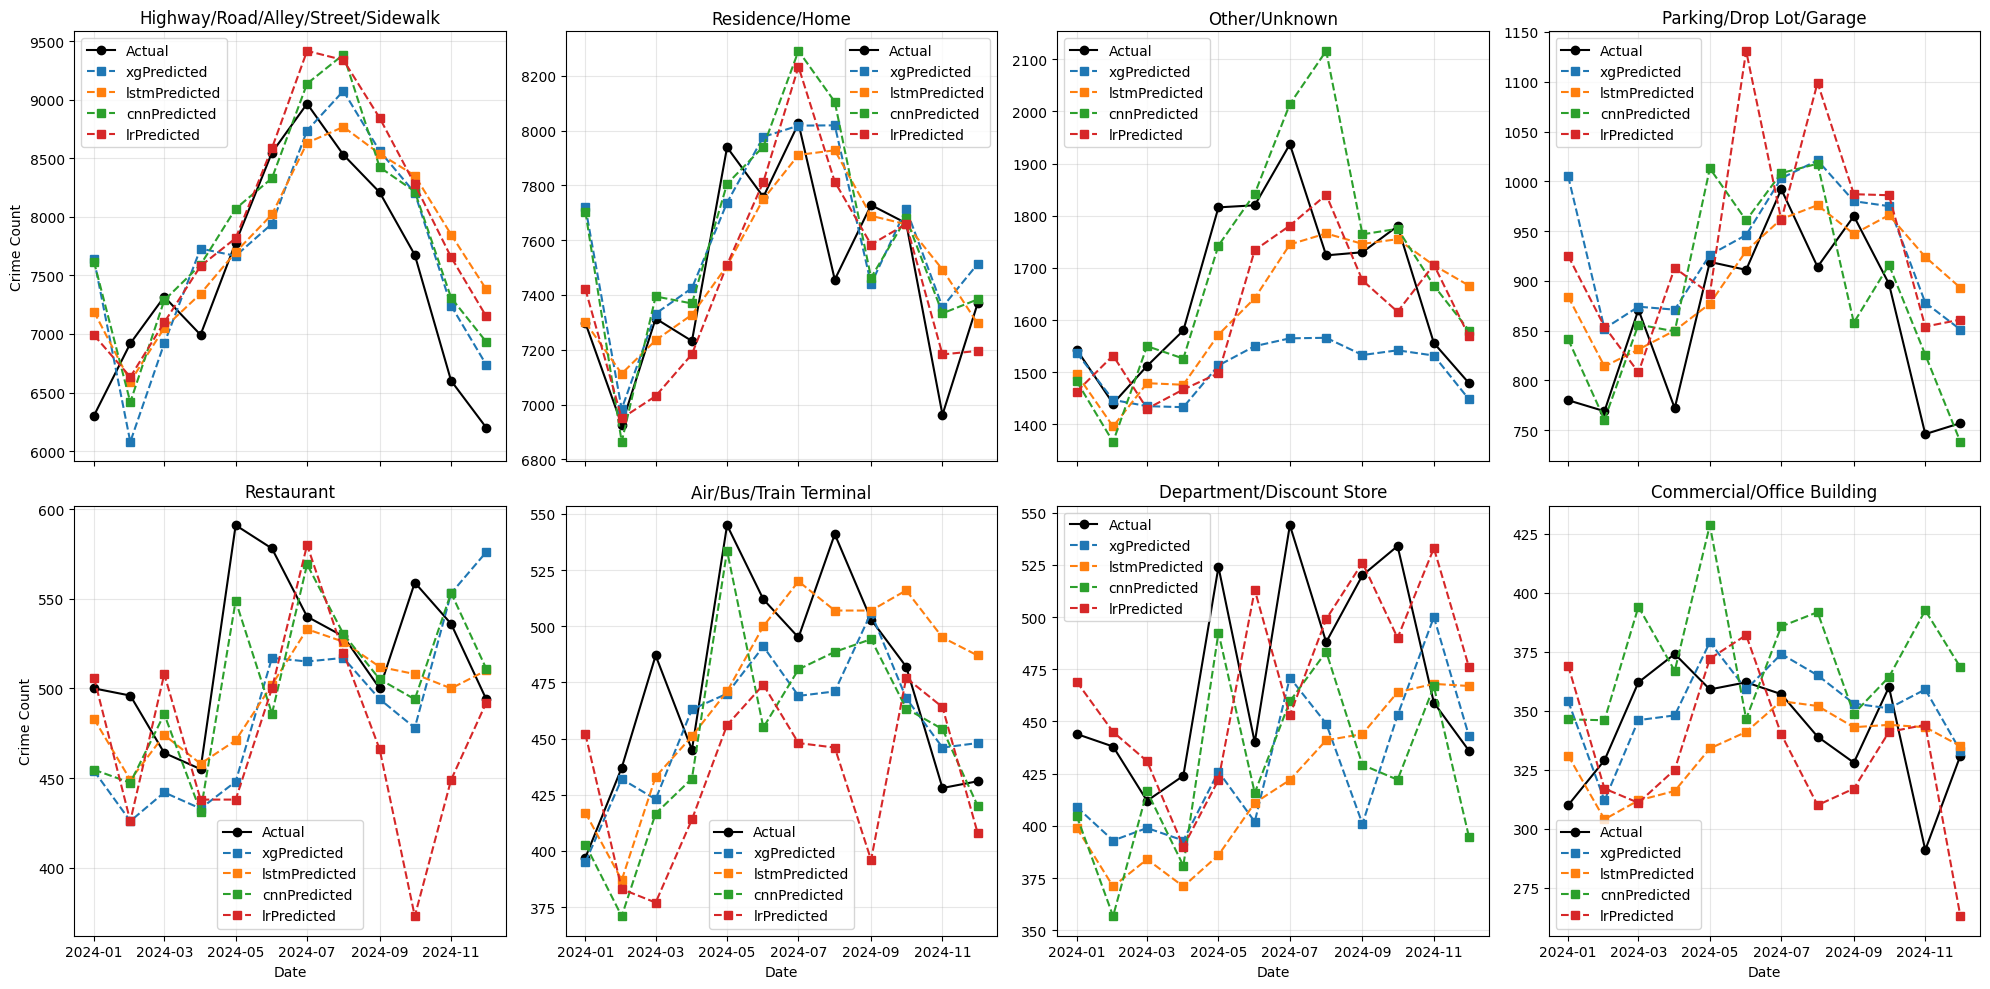

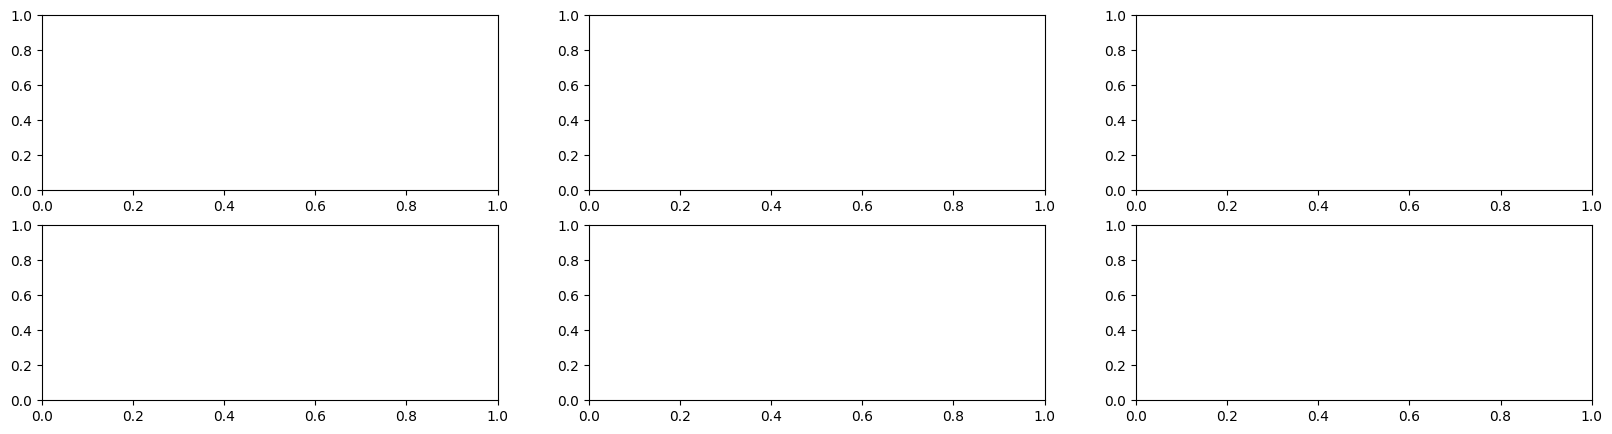

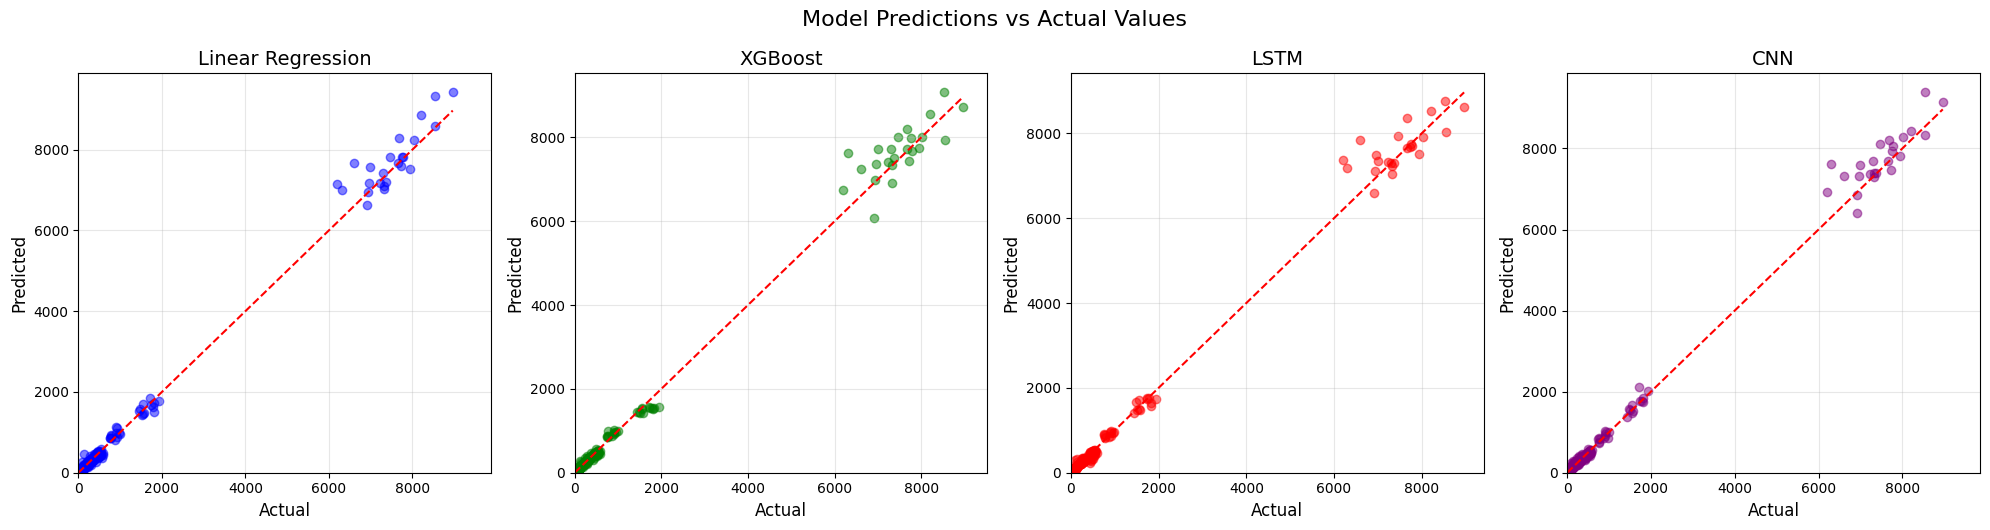

MAPE (%) by Location and Model:
                                    location_name  lr_mape  xg_mape  \
0                          ATM Separate from Bank    99.62    43.35   
1                   Abandoned/Condemned Structure   157.43    62.50   
2                          Air/Bus/Train Terminal    11.89     5.55   
3              Arena/Stadium/Fairgrounds/Coliseum    78.01    39.48   
4                        Auto Dealership New/Used    78.74    38.57   
5                           Bank/Savings and Loan    22.87    22.50   
6                                   Bar/Nightclub    12.91     7.65   
7                  Church/Synagogue/Temple/Mosque    44.68    20.71   
8                      Commercial/Office Building     9.98     6.97   
9                               Construction Site    69.15    30.84   
10                              Convenience Store    15.80     9.38   
11                               Daycare Facility    94.59    33.56   
12                      Department/Discount S

C:\Users\he yihan\AppData\Local\Temp\ipykernel_26468\4014908332.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


In [25]:
# 1. Identify the top 8 locations by total crime count
top8_locations = (
    df_test_result.groupby("location_name")["crime_count"]
    .sum()
    .nlargest(8)
    .index.tolist()
)

# 2. Filter data for these top 8 locations
df_top8 = df_test_result[df_test_result["location_name"].isin(top8_locations)].copy()

# 3. Aggregate monthly data (summing the actual and predicted counts)
df_trend = df_top8.groupby(["location_name", "Year", "Month"], as_index=False).agg(
    crime_count=("crime_count", "sum"),
#     rf_pred=("rf_pred", "sum"),
    xg_pred=("xg_pred", "sum"),
    lr_pred=("lr_pred", "sum"),
    lstm_pred=("lstm_pred", "sum"),
    cnn_pred=("cnn_pred", "sum"),
)

# 4. Create a datetime column for proper time series plotting (using the 1st day of each month)
df_trend["Date"] = pd.to_datetime(
    df_trend["Year"].astype(str) + "-" + df_trend["Month"].astype(str) + "-01"
)

# 5. Plotting in subplots (2 rows x 4 columns for 8 subplots) without sharing the y-axis
fig, axes = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10), sharex=True
)  # Remove sharey to allow independent y-axis
axes = axes.flatten()  # Flatten to iterate easily

for i, loc in enumerate(top8_locations):
    ax = axes[i]
    df_loc = df_trend[df_trend["location_name"] == loc].sort_values("Date")

    # Plot actual crime count
    ax.plot(
        df_loc["Date"],
        df_loc["crime_count"],
        marker="o",
        linestyle="-",
        label="Actual",
        color="black",
    )
    # Plot predicted crime count
    for m in ["xg", "lstm", "cnn","lr"]:
        ax.plot(
            df_loc["Date"],
            df_loc[f"{m}_pred"],
            marker="s",
            linestyle="--",
            label=f"{m}Predicted",
        )

    ax.set_title(loc)
    ax.grid(True, alpha=0.3)

    # Set labels for the leftmost and bottom plots only
    if i % 4 == 0:  # Leftmost plots
        ax.set_ylabel("Crime Count")
    if i >= 4:  # Bottom row plots
        ax.set_xlabel("Date")

    ax.legend()

# Remove any unused subplots (if there are fewer than 8, not applicable here)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("monthly_crime_trends_top8_locations_test_data.pdf", format="pdf")
plt.show()

# Create a figure with 4 subplots (for LR, RF, XGBoost, and LSTM)
fig, axes = plt.subplots(2, 3, figsize=(20, 5))

# Define models, colors, and titles 
models = ["lr_pred", "xg_pred", "lstm_pred", "cnn_pred"]
colors = ["blue", "green", "red", "purple", "orange"]
titles = ["Linear Regression", "XGBoost", "LSTM", "CNN"]

# Create subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust size as needed

# Loop through each model and create scatter plot
for i, (model, color, title) in enumerate(zip(models, colors, titles)):
    # Create scatter plot
    axes[i].scatter(
        df_test_result["crime_count"], df_test_result[model], alpha=0.5, color=color
    )

    # Add diagonal line for perfect predictions
    axes[i].plot(
        [0, df_test_result["crime_count"].max()],
        [0, df_test_result["crime_count"].max()],
        "r--",
    )

    # Add title and labels
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Actual", fontsize=12)
    axes[i].set_ylabel("Predicted", fontsize=12)
    axes[i].grid(True, alpha=0.3)

    # Optional: Set the same limits for all plots for easier comparison
    max_val = max(df_test_result["crime_count"].max(), df_test_result[model].max())
    axes[i].set_xlim(0, max_val * 1.05)
    axes[i].set_ylim(0, max_val * 1.05)

# Adjust layout
plt.tight_layout()
plt.suptitle("Model Predictions vs Actual Values", fontsize=16, y=1.05)
# plt.savefig("model_predictions_vs_actual_values_test_data.pdf", format="pdf")
plt.show()

# mae_by_location = (
#     df_test_result.groupby("location_name")
#     .apply(lambda group: pd.Series({
#         "lr_mae": (group["lr_pred"] - group["crime_count"]).abs().mean(),
# #         "rf_mae": (group["rf_pred"] - group["crime_count"]).abs().mean(),
#         "xg_mae": (group["xg_pred"] - group["crime_count"]).abs().mean(),
#         "lstm_mae": (group["lstm_pred"] - group["crime_count"]).abs().mean(),
#         "cnn_mae": (group["cnn_pred"] - group["crime_count"]).abs().mean(),
#     }))
#     .reset_index()
# )

# # 2. 打印结果
# pd.set_option('display.float_format', lambda x: '%.2f' % x)  # 控制浮点显示格式
# print("Mean Absolute Error (MAE) by Location and Model:\n")
# print(mae_by_location)

# 避免除零
df_test_result = df_test_result[df_test_result["crime_count"] != 0].copy()

mape_by_location = (
    df_test_result.groupby("location_name")
    .apply(lambda group: pd.Series({
        "lr_mape": ((group["lr_pred"] - group["crime_count"]).abs() / group["crime_count"]).mean() * 100,
        "xg_mape": ((group["xg_pred"] - group["crime_count"]).abs() / group["crime_count"]).mean() * 100,
        "lstm_mape": ((group["lstm_pred"] - group["crime_count"]).abs() / group["crime_count"]).mean() * 100,
        "cnn_mape": ((group["cnn_pred"] - group["crime_count"]).abs() / group["crime_count"]).mean() * 100,
    }))
    .reset_index()
)

print("MAPE (%) by Location and Model:")
print(mape_by_location)
